In [1]:
from dataset_creation import TextDataset
from torch.utils.data import DataLoader
import numpy as np

# Instantiate the dataset
text_dataset = TextDataset(directory='data/SPGC-tokens-2018-07-18/', sequence_length=100)
print(f"Dataset created with {len(text_dataset)} sequences.")

# Create a DataLoader without a sampler
dataloader = DataLoader(text_dataset, batch_size=1)

# Iterate over a few batches and print their contents
for i, (sequences, inputs) in enumerate(dataloader):
    if i >= 2:  # Adjust this value to see more/less batches
        break

    print(f"\nBatch {i+1}")
    print(f"Inputs shape: {inputs.shape}")

    # Optionally print the actual sequences (comment out if too verbose)
    sequence = ''.join([text_dataset.idx_to_char[int(idx)] for idx in inputs[0]])
    # target = text_dataset.idx_to_char[int(targets[0])]
    print(f"Sequence: {sequence}")


Dataset created with 18422222637 sequences.

Batch 1
Inputs shape: torch.Size([1, 100])
Sequence: scribed by her before we left home i comprehend now why the water stood in cousin molly eyes while d

Batch 2
Inputs shape: torch.Size([1, 100])
Sequence: our of bitter humiliation if my wrath was unhallowed it wrought the peaceable fruits of righteousnes


In [2]:
import torch
import torch.nn.functional as F

# Define chars using keys of char_to_idx
chars = list(text_dataset.char_to_idx.keys())

n_characters = len(chars)  # Number of unique characters
print(f"Number of unique characters: {n_characters}")
print(f"Characters: {chars}")

Number of unique characters: 70
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.', ';', "'", '"', '?', '!', ' ']


In [3]:
class SimpleRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First layer
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(input_size + hidden_size, hidden_size)])
        # Additional layers
        for _ in range(1, num_layers):
            self.linear_layers.append(torch.nn.Linear(hidden_size, hidden_size))

        # Final layers for hidden and output
        self.i2h = torch.nn.Linear(hidden_size, hidden_size)
        self.i2o = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)

        # Pass through the linear layers with ReLU and Dropout
        for layer in self.linear_layers:
            combined = layer(combined)
            combined = F.relu(combined)

        # Split into hidden and output
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Ensure the input size matches the number of features for each input
input_size = n_characters
output_size = n_characters
n_hidden = 128
rnn = SimpleRNN(input_size, n_hidden, output_size,3)

# Define the loss function (criterion) and optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)



# Apply Gradient Clipping
torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1.0)  # Clip gradients during training


tensor(0.)

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return text_dataset.char_to_idx[letter]

# Just for demonstration, turn a letter into a <1 x n_characters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_characters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_characters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_characters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 1, 70])


In [5]:
text_dataset[3]

(' were matted over the older graves a spreading tree arose near the middle of the badly kept square a',
 tensor([69, 22,  4, 17,  4, 69, 12,  0, 19, 19,  4,  3, 69, 14, 21,  4, 17, 69,
         19,  7,  4, 69, 14, 11,  3,  4, 17, 69,  6, 17,  0, 21,  4, 18, 69,  0,
         69, 18, 15, 17,  4,  0,  3,  8, 13,  6, 69, 19, 17,  4,  4, 69,  0, 17,
         14, 18,  4, 69, 13,  4,  0, 17, 69, 19,  7,  4, 69, 12,  8,  3,  3, 11,
          4, 69, 14,  5, 69, 19,  7,  4, 69,  1,  0,  3, 11, 24, 69, 10,  4, 15,
         19, 69, 18, 16, 20,  0, 17,  4, 69,  0]))

In [6]:
def randomTrainingExample():
    """Generate a random training example from the dataset"""
    sequence, line_tensor = text_dataset[np.random.randint(len(text_dataset))]
    return sequence, line_tensor

randomTrainingExample()

('e should not forget to be thankful it is not possible i believe for any woman to approach more close',
 tensor([ 4, 69, 18,  7, 14, 20, 11,  3, 69, 13, 14, 19, 69,  5, 14, 17,  6,  4,
         19, 69, 19, 14, 69,  1,  4, 69, 19,  7,  0, 13, 10,  5, 20, 11, 69,  8,
         19, 69,  8, 18, 69, 13, 14, 19, 69, 15, 14, 18, 18,  8,  1, 11,  4, 69,
          8, 69,  1,  4, 11,  8,  4, 21,  4, 69,  5, 14, 17, 69,  0, 13, 24, 69,
         22, 14, 12,  0, 13, 69, 19, 14, 69,  0, 15, 15, 17, 14,  0,  2,  7, 69,
         12, 14, 17,  4, 69,  2, 11, 14, 18,  4]))

In [7]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0] -1):
        # Convert to one-hot encoding for each character
        hot_input_char_tensor = torch.nn.functional.one_hot(line_tensor[i], num_classes=n_characters).type(torch.float).unsqueeze(0)
        output, hidden = rnn(hot_input_char_tensor, hidden)

    loss = criterion(output, line_tensor[-1].unsqueeze(0))
    loss.backward()
    # optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [8]:
import time
import math

n_iters = 100000
print_every = 500
plot_every = 10



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    sequence, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        # Use the output to generate a character prediction
        topv, topi = output.topk(1, dim=1)  # Change dim to 1
        predicted_char = text_dataset.idx_to_char[topi[0, 0].item()]
        target_char = sequence[-1]
        correct = '✓' if predicted_char == target_char else '✗ (%s)' % target_char
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, sequence, predicted_char, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 0% (0m 28s) 4.2599 heir power its immediate causes were a series of circumstances which promoted active discontent with /   ✗ (h)
1000 1% (0m 52s) 3.6189  flash show the hand empty then take hold of the right lappet of the coat with the right hand and in /   ✗ (n)
1500 1% (1m 23s) 3.3057  the east for a hundred days journey more all round arabia and india among forests full of elephants /   ✗ (s)
2000 2% (1m 47s) 1.7706 ond de de la conduite du roi à son égard vandervynckt troubles des tom ii seu vera seu ficta facilè  /   ✓
2500 2% (2m 9s) 2.8606 ave of his hand your own rows gintlemen i do give a damn whether megales or valdez is governor of ch /   ✗ (h)
3000 3% (2m 30s) 2.8182 you ought to be shut up you horrible man she cried and you will be i see to that now do be plumb foo / e ✗ (o)
3500 3% (2m 53s) 2.6989 o ruin one of these towers had been converted into a pleasure resort by the vagabonds there was a in /   ✗ (n)
4000 4% (3m 22s) 2.8390  theodule te laten bespieden nu beslo

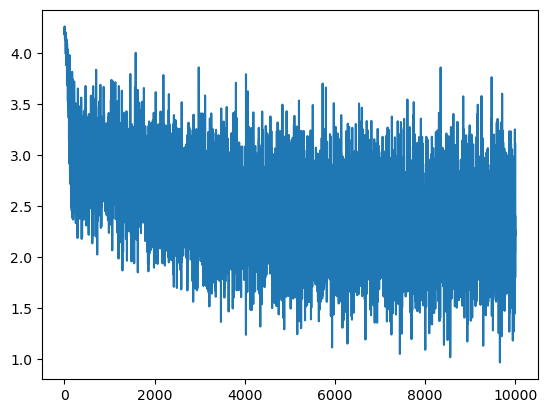

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)